In [51]:
# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive')

# TODO: Enter the foldername in your Drive where you have saved the unzipped
# assignment folder, e.g. 'cs231n/assignments/assignment1/'
FOLDERNAME = 'cs231n/assignments/assignment1/'
assert FOLDERNAME is not None, "[!] Enter the foldername."

# Now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

# This downloads the CIFAR-10 dataset to your Drive
# if it doesn't already exist.
%cd /content/drive/My\ Drive/$FOLDERNAME/cs231n/datasets/
!bash get_datasets.sh
%cd /content/drive/My\ Drive/$FOLDERNAME

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/cs231n/assignments/assignment1/cs231n/datasets
/content/drive/My Drive/cs231n/assignments/assignment1


# Fully-Connected Neural Nets
In this exercise we will implement fully-connected networks using a modular approach. For each layer we will implement a `forward` and a `backward` function. The `forward` function will receive inputs, weights, and other parameters and will return both an output and a `cache` object storing data needed for the backward pass, like this:

```python
def layer_forward(x, w):
  """ Receive inputs x and weights w """
  # Do some computations ...
  z = # ... some intermediate value
  # Do some more computations ...
  out = # the output
   
  cache = (x, w, z, out) # Values we need to compute gradients
   
  return out, cache
```

The backward pass will receive upstream derivatives and the `cache` object, and will return gradients with respect to the inputs and weights, like this:

```python
def layer_backward(dout, cache):
  """
  Receive dout (derivative of loss with respect to outputs) and cache,
  and compute derivative with respect to inputs.
  """
  # Unpack cache values
  x, w, z, out = cache
  
  # Use values in cache to compute derivatives
  dx = # Derivative of loss with respect to x
  dw = # Derivative of loss with respect to w
  
  return dx, dw
```

After implementing a bunch of layers this way, we will be able to easily combine them to build classifiers with different architectures.
  

In [52]:
# As usual, a bit of setup
from __future__ import print_function
import time
import numpy as np
import matplotlib.pyplot as plt
from cs231n.classifiers.fc_net import *
from cs231n.data_utils import get_CIFAR10_data
from cs231n.gradient_check import eval_numerical_gradient, eval_numerical_gradient_array
from cs231n.solver import Solver

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

def rel_error(x, y):
  """ returns relative error """
  return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [53]:
# Load the (preprocessed) CIFAR10 data.

data = get_CIFAR10_data()
for k, v in list(data.items()):
  print(('%s: ' % k, v.shape))

('X_train: ', (49000, 3, 32, 32))
('y_train: ', (49000,))
('X_val: ', (1000, 3, 32, 32))
('y_val: ', (1000,))
('X_test: ', (1000, 3, 32, 32))
('y_test: ', (1000,))


# Affine layer: forward
Open the file `cs231n/layers.py` and implement the `affine_forward` function.

Once you are done you can test your implementaion by running the following:

In [ ]:
# Test the affine_forward function

num_inputs = 2
input_shape = (4, 5, 6)
output_dim = 3

input_size = num_inputs * np.prod(input_shape)
weight_size = output_dim * np.prod(input_shape)

x = np.linspace(-0.1, 0.5, num=input_size).reshape(num_inputs, *input_shape)
w = np.linspace(-0.2, 0.3, num=weight_size).reshape(np.prod(input_shape), output_dim)
b = np.linspace(-0.3, 0.1, num=output_dim)

out, _ = affine_forward(x, w, b)
correct_out = np.array([[ 1.49834967,  1.70660132,  1.91485297],
                        [ 3.25553199,  3.5141327,   3.77273342]])

# Compare your output with ours. The error should be around e-9 or less.
print('Testing affine_forward function:')
print('difference: ', rel_error(out, correct_out))

Testing affine_forward function:
difference:  9.769849468192957e-10


In [ ]:
# 다음은 정답코드입니다.
# def affine_forward(x, w, b):
#     """
#     Computes the forward pass for an affine (fully-connected) layer.

#     The input x has shape (N, d_1, ..., d_k) and contains a minibatch of N
#     examples, where each example x[i] has shape (d_1, ..., d_k). We will
#     reshape each input into a vector of dimension D = d_1 * ... * d_k, and
#     then transform it to an output vector of dimension M.

#     Inputs:
#     - x: A numpy array containing input data, of shape (N, d_1, ..., d_k)
#     - w: A numpy array of weights, of shape (D, M)
#     - b: A numpy array of biases, of shape (M,)

#     Returns a tuple of:
#     - out: output, of shape (N, M)
#     - cache: (x, w, b)
#     """
#     out = None
#     ###########################################################################
#     # TODO: Implement the affine forward pass. Store the result in out. You   #
#     # will need to reshape the input into rows.                               #
#     ###########################################################################
#     # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

#     num_train = x.shape[0]
#     out = np.dot(np.reshape(x,[num_train,-1]),w) + b

#     # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
#     ###########################################################################
#     #                             END OF YOUR CODE                            #
#     ###########################################################################
#     cache = (x, w, b)
#     return out, cache

# Affine layer: backward
Now implement the `affine_backward` function and test your implementation using numeric gradient checking.

In [ ]:
# Test the affine_backward function
np.random.seed(231)
x = np.random.randn(10, 2, 3)
w = np.random.randn(6, 5)
b = np.random.randn(5)
dout = np.random.randn(10, 5)

dx_num = eval_numerical_gradient_array(lambda x: affine_forward(x, w, b)[0], x, dout)
dw_num = eval_numerical_gradient_array(lambda w: affine_forward(x, w, b)[0], w, dout)
db_num = eval_numerical_gradient_array(lambda b: affine_forward(x, w, b)[0], b, dout)

_, cache = affine_forward(x, w, b)
dx, dw, db = affine_backward(dout, cache)

# The error should be around e-10 or less
print('Testing affine_backward function:')
print('dx error: ', rel_error(dx_num, dx))
print('dw error: ', rel_error(dw_num, dw))
print('db error: ', rel_error(db_num, db))

Testing affine_backward function:
dx error:  5.399100368651805e-11
dw error:  9.904211865398145e-11
db error:  2.4122867568119087e-11


# ReLU activation: forward
Implement the forward pass for the ReLU activation function in the `relu_forward` function and test your implementation using the following:

In [ ]:
#다음은 정답코드입니다.
#ReLu함수는..0보다 크면 그대로 반환하고 0보다 작으면 0을 반환하는 함수이다.
def relu_forward(x):
    """
    Computes the forward pass for a layer of rectified linear units (ReLUs).

    Input:
    - x: Inputs, of any shape

    Returns a tuple of:
    - out: Output, of the same shape as x
    - cache: x
    """
    out = None
    ###########################################################################
    # TODO: Implement the ReLU forward pass.                                  #
    ###########################################################################
    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

    out = np.maximum(0,x)

    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################
    cache = x
    return out, cache

In [ ]:
# Test the relu_forward function

x = np.linspace(-0.5, 0.5, num=12).reshape(3, 4)

out, _ = relu_forward(x)
correct_out = np.array([[ 0.,          0.,          0.,          0.,        ],
                        [ 0.,          0.,          0.04545455,  0.13636364,],
                        [ 0.22727273,  0.31818182,  0.40909091,  0.5,       ]])

# Compare your output with ours. The error should be on the order of e-8
print('Testing relu_forward function:')
print('difference: ', rel_error(out, correct_out))

Testing relu_forward function:
difference:  4.999999798022158e-08


# ReLU activation: backward
Now implement the backward pass for the ReLU activation function in the `relu_backward` function and test your implementation using numeric gradient checking:

In [ ]:
#다음은 정답코드입니다.
def relu_backward(dout, cache):
    """
    Computes the backward pass for a layer of rectified linear units (ReLUs).

    Input:
    - dout: Upstream derivatives, of any shape
    - cache: Input x, of same shape as dout

    Returns:
    - dx: Gradient with respect to x
    """
    dx, x = None, cache
    ###########################################################################
    # TODO: Implement the ReLU backward pass.                                 #
    ###########################################################################
    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

    dx = dout * (x > 0)

    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################
    return dx

In [ ]:
np.random.seed(231)
x = np.random.randn(10, 10)
dout = np.random.randn(*x.shape)

dx_num = eval_numerical_gradient_array(lambda x: relu_forward(x)[0], x, dout)

_, cache = relu_forward(x)
dx = relu_backward(dout, cache)

# The error should be on the order of e-12
print('Testing relu_backward function:')
print('dx error: ', rel_error(dx_num, dx))

Testing relu_backward function:
dx error:  3.2756349136310288e-12


## Inline Question 1:

We've only asked you to implement ReLU, but there are a number of different activation functions that one could use in neural networks, each with its pros and cons. In particular, an issue commonly seen with activation functions is getting zero (or close to zero) gradient flow during backpropagation. Which of the following activation functions have this problem? If you consider these functions in the one dimensional case, what types of input would lead to this behaviour?
1. Sigmoid
2. ReLU
3. Leaky ReLU

## Answer:
1,2번 활성화 함수 모두 기울기가 0인 문제가 발생할 수 있으며 이를 해결한 것이 3번 활성화 함수이다.

Sigmoid의 경우 입력값(x)이 매우 커질 경우 0에 가까워지게 된다.
또한 ReLu함수의 경우 음수의 경우 0을 출력하는 문제가 있다.

이를 해결한 것이 Leaky ReLu로 x가 음수의 값을 가질 때 아주 작은 양수(epsilon)를 부여하여 Gradient가 0이 되는 문제를 방지한다.

# "Sandwich" layers
There are some common patterns of layers that are frequently used in neural nets. For example, affine layers are frequently followed by a ReLU nonlinearity. To make these common patterns easy, we define several convenience layers in the file `cs231n/layer_utils.py`.

For now take a look at the `affine_relu_forward` and `affine_relu_backward` functions, and run the following to numerically gradient check the backward pass:

In [ ]:
from cs231n.layer_utils import affine_relu_forward, affine_relu_backward
np.random.seed(231)
x = np.random.randn(2, 3, 4)
w = np.random.randn(12, 10)
b = np.random.randn(10)
dout = np.random.randn(2, 10)

out, cache = affine_relu_forward(x, w, b)
dx, dw, db = affine_relu_backward(dout, cache)

dx_num = eval_numerical_gradient_array(lambda x: affine_relu_forward(x, w, b)[0], x, dout)
dw_num = eval_numerical_gradient_array(lambda w: affine_relu_forward(x, w, b)[0], w, dout)
db_num = eval_numerical_gradient_array(lambda b: affine_relu_forward(x, w, b)[0], b, dout)

# Relative error should be around e-10 or less
print('Testing affine_relu_forward and affine_relu_backward:')
print('dx error: ', rel_error(dx_num, dx))
print('dw error: ', rel_error(dw_num, dw))
print('db error: ', rel_error(db_num, db))

Testing affine_relu_forward and affine_relu_backward:
dx error:  2.299579177309368e-11
dw error:  8.162011105764925e-11
db error:  7.826724021458994e-12


# Loss layers: Softmax and SVM
Now implement the loss and gradient for softmax and SVM in the `softmax_loss` and `svm_loss` function in `cs231n/layers.py`. These should be similar to what you implemented in `cs231n/classifiers/softmax.py` and `cs231n/classifiers/linear_svm.py`.

You can make sure that the implementations are correct by running the following:

In [ ]:
# 다음은 정답코드입니다.
# def svm_loss(x, y):
#     """
#     Computes the loss and gradient using for multiclass SVM classification.

#     Inputs:
#     - x: Input data, of shape (N, C) where x[i, j] is the score for the jth
#       class for the ith input.
#     - y: Vector of labels, of shape (N,) where y[i] is the label for x[i] and
#       0 <= y[i] < C

#     Returns a tuple of:
#     - loss: Scalar giving the loss
#     - dx: Gradient of the loss with respect to x
#     """
#     loss, dx = None, None

#     ###########################################################################
#     # TODO: Copy over your solution from A1.
#     ###########################################################################
#     # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

#     N, C = x.shape
#     correct_class_scores = x[np.arange(N), y].reshape(N, 1)  # 정답 클래스 점수
#     margins = np.maximum(0, x - correct_class_scores + 1)    # 마진 계산
#     margins[np.arange(N), y] = 0                            # 정답 클래스 마진은 제외
#     loss = np.sum(margins) / N                              # 평균 손실 계산

#     # Gradient
#     binary = margins > 0
#     binary = binary.astype(float)
#     binary[np.arange(N), y] = -np.sum(binary, axis=1)
#     dx = binary / N

#     # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
#     ###########################################################################
#     #                             END OF YOUR CODE                            #
#     ###########################################################################
#     return loss, dx


# def softmax_loss(x, y):
#     """
#     Computes the loss and gradient for softmax classification.

#     Inputs:
#     - x: Input data, of shape (N, C) where x[i, j] is the score for the jth
#       class for the ith input.
#     - y: Vector of labels, of shape (N,) where y[i] is the label for x[i] and
#       0 <= y[i] < C

#     Returns a tuple of:
#     - loss: Scalar giving the loss
#     - dx: Gradient of the loss with respect to x
#     """
#     loss, dx = None, None

#     ###########################################################################
#     # TODO: Copy over your solution from A1.
#     ###########################################################################
#     # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

#     num_train = x.shape[0]

#     # 점수 안정성을 위해 최대값 제거
#     scores = x

#     # 소프트맥스 확률 계산
#     exp_scores = np.exp(scores)
#     probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

#     # 손실 계산
#     correct_log_probs = -np.log(probs[np.arange(num_train), y])
#     loss = np.sum(correct_log_probs) / num_train

#     # 그래디언트 계산
#     dx = probs
#     dx[np.arange(num_train), y] -= 1
#     dx /= num_train

#     # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
#     ###########################################################################
#     #                             END OF YOUR CODE                            #
#     ###########################################################################
#     return loss, dx

In [ ]:
np.random.seed(231)
num_classes, num_inputs = 10, 50
x = 0.001 * np.random.randn(num_inputs, num_classes)
y = np.random.randint(num_classes, size=num_inputs)

dx_num = eval_numerical_gradient(lambda x: svm_loss(x, y)[0], x, verbose=False)
loss, dx = svm_loss(x, y)

# Test svm_loss function. Loss should be around 9 and dx error should be around the order of e-9
print('Testing svm_loss:')
print('loss: ', loss)
print('dx error: ', rel_error(dx_num, dx))

dx_num = eval_numerical_gradient(lambda x: softmax_loss(x, y)[0], x, verbose=False)
loss, dx = softmax_loss(x, y)

# Test softmax_loss function. Loss should be close to 2.3 and dx error should be around e-8
print('\nTesting softmax_loss:')
print('loss: ', loss)
print('dx error: ', rel_error(dx_num, dx))

Testing svm_loss:
loss:  8.999602749096233
dx error:  1.4021566006651672e-09

Testing softmax_loss:
loss:  2.302545844500738
dx error:  9.483503037636722e-09


# Two-layer network
Open the file `cs231n/classifiers/fc_net.py` and complete the implementation of the `TwoLayerNet` class. Read through it to make sure you understand the API. You can run the cell below to test your implementation.

In [ ]:
#다음은 정답코드입니다.
# class TwoLayerNet(object):
#     """
#     A two-layer fully-connected neural network with ReLU nonlinearity and
#     softmax loss that uses a modular layer design. We assume an input dimension
#     of D, a hidden dimension of H, and perform classification over C classes.

#     The architecure should be affine - relu - affine - softmax.

#     Note that this class does not implement gradient descent; instead, it
#     will interact with a separate Solver object that is responsible for running
#     optimization.

#     The learnable parameters of the model are stored in the dictionary
#     self.params that maps parameter names to numpy arrays.
#     """

#     def __init__(
#         self,
#         input_dim=3 * 32 * 32,
#         hidden_dim=100,
#         num_classes=10,
#         weight_scale=1e-3,
#         reg=0.0,
#     ):
#         """
#         Initialize a new network.

#         Inputs:
#         - input_dim: An integer giving the size of the input
#         - hidden_dim: An integer giving the size of the hidden layer
#         - num_classes: An integer giving the number of classes to classify
#         - weight_scale: Scalar giving the standard deviation for random
#           initialization of the weights.
#         - reg: Scalar giving L2 regularization strength.
#         """
#         self.params = {}
#         self.reg = reg

#         ############################################################################
#         # TODO: Initialize the weights and biases of the two-layer net. Weights    #
#         # should be initialized from a Gaussian centered at 0.0 with               #
#         # standard deviation equal to weight_scale, and biases should be           #
#         # initialized to zero. All weights and biases should be stored in the      #
#         # dictionary self.params, with first layer weights                         #
#         # and biases using the keys 'W1' and 'b1' and second layer                 #
#         # weights and biases using the keys 'W2' and 'b2'.                         #
#         ############################################################################
#         # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

#         #np.random.randn을 활용 -> 1) mu = 0이고 sigma = 1인 nd에서 난수 생성 2) np.random.randn(2,3)은 2행 3열임.
#         self.params['W1'] = weight_scale * np.random.randn(input_dim, hidden_dim)
#         self.params['b1'] = np.zeros(hidden_dim)

#         self.params['W2'] = weight_scale * np.random.randn(hidden_dim, num_classes)
#         self.params['b2'] = np.zeros(num_classes)


#         # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
#         ############################################################################
#         #                             END OF YOUR CODE                             #
#         ############################################################################

#     def loss(self, X, y=None):
#         """
#         Compute loss and gradient for a minibatch of data.

#         Inputs:
#         - X: Array of input data of shape (N, d_1, ..., d_k)
#         - y: Array of labels, of shape (N,). y[i] gives the label for X[i].

#         Returns:
#         If y is None, then run a test-time forward pass of the model and return:
#         - scores: Array of shape (N, C) giving classification scores, where
#           scores[i, c] is the classification score for X[i] and class c.

#         If y is not None, then run a training-time forward and backward pass and
#         return a tuple of:
#         - loss: Scalar value giving the loss
#         - grads: Dictionary with the same keys as self.params, mapping parameter
#           names to gradients of the loss with respect to those parameters.
#         """
#         scores = None
#         ############################################################################
#         # TODO: Implement the forward pass for the two-layer net, computing the    #
#         # class scores for X and storing them in the scores variable.              #
#         ############################################################################
#         # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
#         #affine1 -> relu -> affine2 -> softMax 순으로 구현할 것. (two_layers)
#         X = X.reshape(X.shape[0], -1)  # (N, 3*32*32)
#         #affine_1
#         affine_1 = X.dot(self.params['W1']) + self.params['b1'] # 입력(x) * weight + bias

#         #ReLu
#         ReLu = np.maximum(0,affine_1)

#         #affine_2
#         scores = ReLu.dot(self.params['W2']) + self.params['b2']  # affine_2 결과를 scores에 저장
#         # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
#         ############################################################################
#         #                             END OF YOUR CODE                             #
#         ############################################################################

#         # If y is None then we are in test mode so just return scores
#         if y is None:
#             return scores

#         loss, grads = 0, {}
#         ############################################################################
#         # TODO: Implement the backward pass for the two-layer net. Store the loss  #
#         # in the loss variable and gradients in the grads dictionary. Compute data #
#         # loss using softmax, and make sure that grads[k] holds the gradients for  #
#         # self.params[k]. Don't forget to add L2 regularization!                   #
#         #                                                                          #
#         # NOTE: To ensure that your implementation matches ours and you pass the   #
#         # automated tests, make sure that your L2 regularization includes a factor #
#         # of 0.5 to simplify the expression for the gradient.                      #
#         ############################################################################
#         # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

#         # Loss
#         num_train = X.shape[0]
#         scores = scores
#         softmax_probs = np.exp(scores) / np.sum(np.exp(scores), axis=1, keepdims=True)
#         loss = -np.sum(np.log(softmax_probs[np.arange(num_train), y])) / num_train

#         # Add L2 regularization to the loss
#         loss += 0.5 * self.reg * (np.sum(self.params['W1'] ** 2) + np.sum(self.params['W2'] ** 2))

#         # Backward pass
#         grads = {}
#         dscores = softmax_probs
#         dscores[np.arange(num_train), y] -= 1 #정답 클래스에서만 -1 -> 손실 계산
#         dscores /= num_train

#         # Gradients for second affine layer
#         grads['W2'] = ReLu.T.dot(dscores) + self.reg * self.params['W2']
#         grads['b2'] = np.sum(dscores, axis=0)

#         # Gradients for ReLU
#         da1 = dscores.dot(self.params['W2'].T)
#         dz1 = da1
#         dz1[affine_1 <= 0] = 0  # ReLU backward pass

#         # Gradients for first affine layer
#         grads['W1'] = X.T.dot(dz1) + self.reg * self.params['W1']
#         grads['b1'] = np.sum(dz1, axis=0)

#         # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
#         ############################################################################
#         #                             END OF YOUR CODE                             #
#         ############################################################################

#         return loss, grads

In [ ]:
np.random.seed(231)
N, D, H, C = 3, 5, 50, 7
X = np.random.randn(N, D)
y = np.random.randint(C, size=N)

std = 1e-3
model = TwoLayerNet(input_dim=D, hidden_dim=H, num_classes=C, weight_scale=std)

print('Testing initialization ... ')
W1_std = abs(model.params['W1'].std() - std)
b1 = model.params['b1']
W2_std = abs(model.params['W2'].std() - std)
b2 = model.params['b2']
assert W1_std < std / 10, 'First layer weights do not seem right'
assert np.all(b1 == 0), 'First layer biases do not seem right'
assert W2_std < std / 10, 'Second layer weights do not seem right'
assert np.all(b2 == 0), 'Second layer biases do not seem right'

print('Testing test-time forward pass ... ')
model.params['W1'] = np.linspace(-0.7, 0.3, num=D*H).reshape(D, H)
model.params['b1'] = np.linspace(-0.1, 0.9, num=H)
model.params['W2'] = np.linspace(-0.3, 0.4, num=H*C).reshape(H, C)
model.params['b2'] = np.linspace(-0.9, 0.1, num=C)
X = np.linspace(-5.5, 4.5, num=N*D).reshape(D, N).T
scores = model.loss(X)
correct_scores = np.asarray(
  [[11.53165108,  12.2917344,   13.05181771,  13.81190102,  14.57198434, 15.33206765,  16.09215096],
   [12.05769098,  12.74614105,  13.43459113,  14.1230412,   14.81149128, 15.49994135,  16.18839143],
   [12.58373087,  13.20054771,  13.81736455,  14.43418138,  15.05099822, 15.66781506,  16.2846319 ]])
scores_diff = np.abs(scores - correct_scores).sum()
assert scores_diff < 1e-6, 'Problem with test-time forward pass'

print('Testing training loss (no regularization)')
y = np.asarray([0, 5, 1])
loss, grads = model.loss(X, y)
correct_loss = 3.4702243556
assert abs(loss - correct_loss) < 1e-10, 'Problem with training-time loss'

model.reg = 1.0
loss, grads = model.loss(X, y)
correct_loss = 26.5948426952
assert abs(loss - correct_loss) < 1e-10, 'Problem with regularization loss'

# Errors should be around e-7 or less
for reg in [0.0, 0.7]:
  print('Running numeric gradient check with reg = ', reg)
  model.reg = reg
  loss, grads = model.loss(X, y)

  for name in sorted(grads):
    f = lambda _: model.loss(X, y)[0]
    grad_num = eval_numerical_gradient(f, model.params[name], verbose=False)
    print('%s relative error: %.2e' % (name, rel_error(grad_num, grads[name])))

Testing initialization ... 
Testing test-time forward pass ... 
Testing training loss (no regularization)
Running numeric gradient check with reg =  0.0
W1 relative error: 1.83e-08
W2 relative error: 3.31e-10
b1 relative error: 9.83e-09
b2 relative error: 4.33e-10
Running numeric gradient check with reg =  0.7
W1 relative error: 2.53e-07
W2 relative error: 2.85e-08
b1 relative error: 1.56e-08
b2 relative error: 7.76e-10


# Solver
Open the file `cs231n/solver.py` and read through it to familiarize yourself with the API. After doing so, use a `Solver` instance to train a `TwoLayerNet` that achieves about `36%` accuracy on the validation set.

In [55]:
input_size = 32 * 32 * 3
hidden_size = 50
num_classes = 10
model = TwoLayerNet(input_size, hidden_size, num_classes)
solver = None

##############################################################################
# TODO: Use a Solver instance to train a TwoLayerNet that achieves about 36% #
# accuracy on the validation set.                                            #
##############################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
#24.12.31 "ValueError: shapes (100,3,32,32) and (3072,50) not aligned: 32 (dim 3) != 3072 (dim 0)"가 발생함.
#TwoLayerNet에서 X(입력)에서는 (100,3,32,32)를 갖는데 self.params['w1']에서는 (3072,50)을 가지고 있음.

# Train the network
solver = Solver(model, data, optim_config={'learning_rate': 1e-3})
solver.train()

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
##############################################################################
#                             END OF YOUR CODE                               #
##############################################################################

(Iteration 1 / 4900) loss: 2.302475
(Epoch 0 / 10) train acc: 0.158000; val_acc: 0.140000
(Iteration 11 / 4900) loss: 2.253149
(Iteration 21 / 4900) loss: 2.197082
(Iteration 31 / 4900) loss: 2.028762
(Iteration 41 / 4900) loss: 2.024874
(Iteration 51 / 4900) loss: 1.927550
(Iteration 61 / 4900) loss: 2.077400
(Iteration 71 / 4900) loss: 1.908015
(Iteration 81 / 4900) loss: 1.817398
(Iteration 91 / 4900) loss: 1.930624
(Iteration 101 / 4900) loss: 1.730822
(Iteration 111 / 4900) loss: 2.011873
(Iteration 121 / 4900) loss: 1.753526
(Iteration 131 / 4900) loss: 1.628237
(Iteration 141 / 4900) loss: 1.743606
(Iteration 151 / 4900) loss: 1.758876
(Iteration 161 / 4900) loss: 1.744477
(Iteration 171 / 4900) loss: 1.824973
(Iteration 181 / 4900) loss: 2.006028
(Iteration 191 / 4900) loss: 1.809035
(Iteration 201 / 4900) loss: 1.668425
(Iteration 211 / 4900) loss: 1.773344
(Iteration 221 / 4900) loss: 1.596342
(Iteration 231 / 4900) loss: 1.894061
(Iteration 241 / 4900) loss: 1.658575
(Iterat

# Debug the training
With the default parameters we provided above, you should get a validation accuracy of about 0.36 on the validation set. This isn't very good.

One strategy for getting insight into what's wrong is to plot the loss function and the accuracies on the training and validation sets during optimization.

Another strategy is to visualize the weights that were learned in the first layer of the network. In most neural networks trained on visual data, the first layer weights typically show some visible structure when visualized.

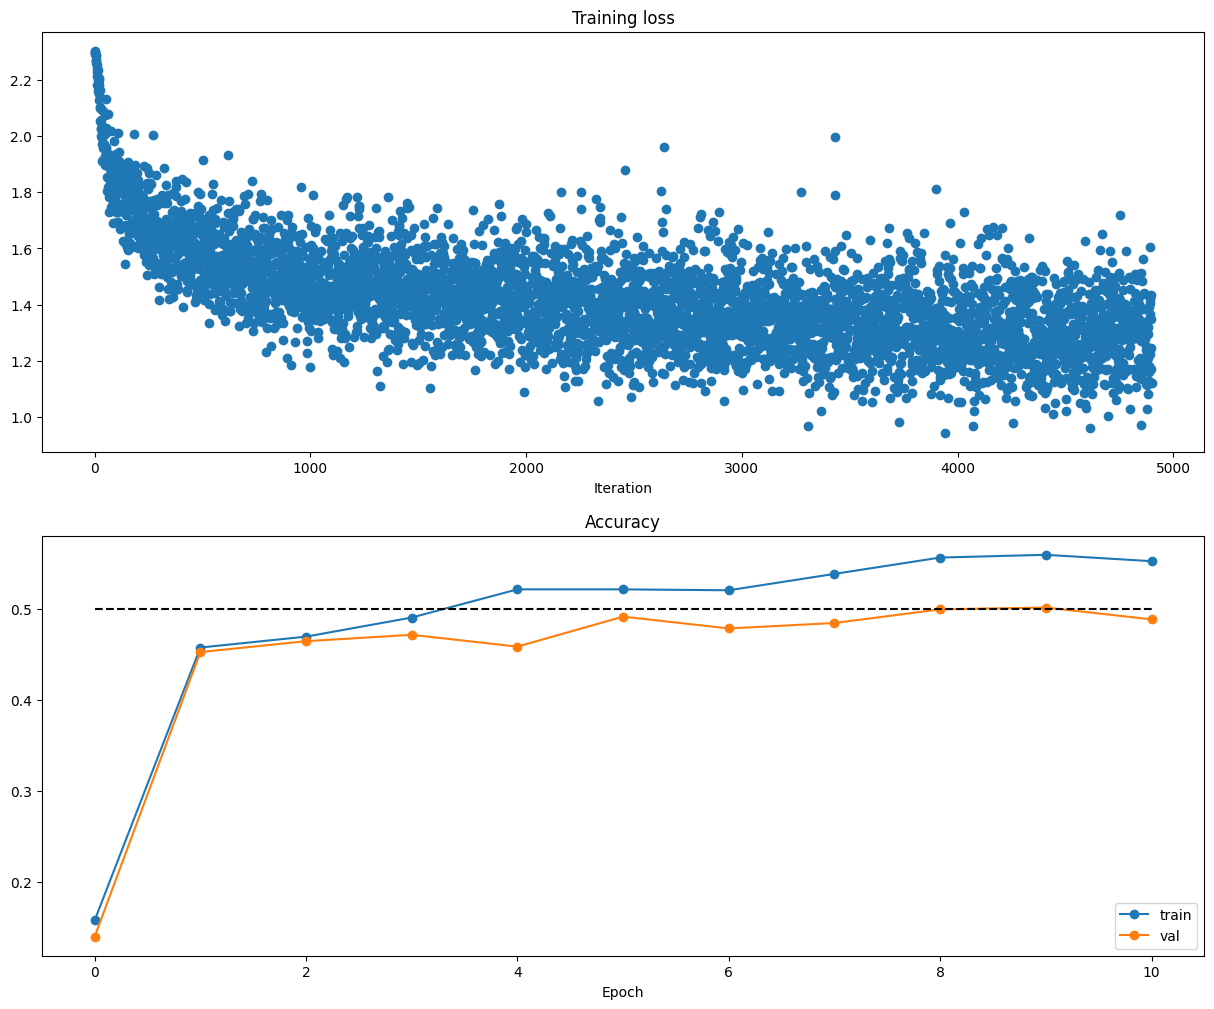

In [56]:
# Run this cell to visualize training loss and train / val accuracy

plt.subplot(2, 1, 1)
plt.title('Training loss')
plt.plot(solver.loss_history, 'o')
plt.xlabel('Iteration')

plt.subplot(2, 1, 2)
plt.title('Accuracy')
plt.plot(solver.train_acc_history, '-o', label='train')
plt.plot(solver.val_acc_history, '-o', label='val')
plt.plot([0.5] * len(solver.val_acc_history), 'k--')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.gcf().set_size_inches(15, 12)
plt.show()

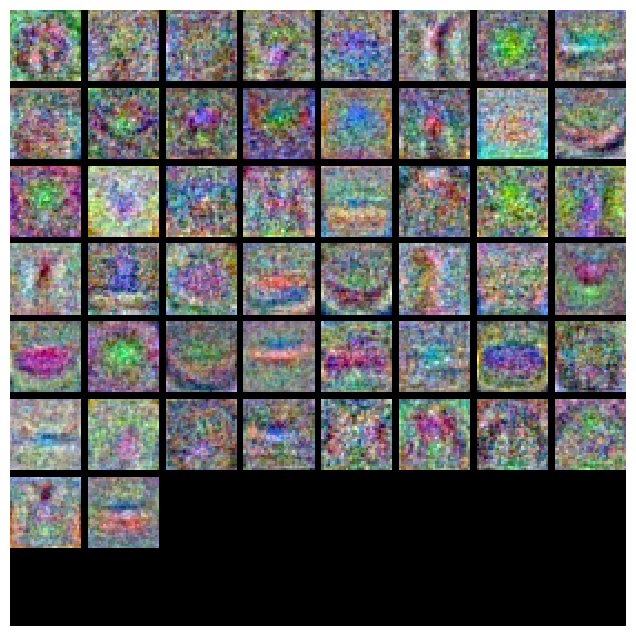

In [57]:
from cs231n.vis_utils import visualize_grid

# Visualize the weights of the network

def show_net_weights(net):
    W1 = net.params['W1']
    W1 = W1.reshape(3, 32, 32, -1).transpose(3, 1, 2, 0)
    plt.imshow(visualize_grid(W1, padding=3).astype('uint8'))
    plt.gca().axis('off')
    plt.show()

show_net_weights(model)

**나의 주석..**

hidden layer는 layer_1과 2사이에 위치하는 layer들이다. 이 layer들을 통해서 컴퓨터가 특징을 학습하게 될 것이다.

lecture_5에서 말했던 바와 같이, 각 layer들은 서로다른 특징을 학습한다. 그러나 하나의 class에 대해서 너무나 많은 layer가 존재한다면 오히려 분류에 어려움을 겪을 수 있겠다.

# Tune your hyperparameters

**What's wrong?**. Looking at the visualizations above, we see that the loss is decreasing more or less linearly, which seems to suggest that the learning rate may be too low. Moreover, there is no gap between the training and validation accuracy, suggesting that the model we used has low capacity, and that we should increase its size. On the other hand, with a very large model we would expect to see more overfitting, which would manifest itself as a very large gap between the training and validation accuracy.

**Tuning**. Tuning the hyperparameters and developing intuition for how they affect the final performance is a large part of using Neural Networks, so we want you to get a lot of practice. Below, you should experiment with different values of the various hyperparameters, including hidden layer size, learning rate, numer of training epochs, and regularization strength. You might also consider tuning the learning rate decay, but you should be able to get good performance using the default value.

**Approximate results**. You should be aim to achieve a classification accuracy of greater than 48% on the validation set. Our best network gets over 52% on the validation set.

**Experiment**: You goal in this exercise is to get as good of a result on CIFAR-10 as you can (52% could serve as a reference), with a fully-connected Neural Network. Feel free implement your own techniques (e.g. PCA to reduce dimensionality, or adding dropout, or adding features to the solver, etc.).

In [64]:
best_model = None
best_accuracy = 0
#################################################################################
# TODO: Tune hyperparameters using the validation set. Store your best trained  #
# model in best_model.                                                          #
#                                                                               #
# To help debug your network, it may help to use visualizations similar to the  #
# ones we used above; these visualizations will have significant qualitative    #
# differences from the ones we saw above for the poorly tuned network.          #
#                                                                               #
# Tweaking hyperparameters by hand can be fun, but you might find it useful to  #
# write code to sweep through possible combinations of hyperparameters          #
# automatically like we did on thexs previous exercises.                          #
#################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
learning_rate=[1e-4,1e-3]
regularization_strength=[1e-5,1e-4,1e-3]
results={}
for lr in learning_rate: # code from previous execise
  for reg in regularization_strength:
    model=TwoLayerNet(input_size, hidden_size, num_classes,reg=reg)
    solver=Solver(model,data, optim_config={'learning_rate': lr},num_epochs=10,batch_size=200,print_every=1000)
    solver.train()

    accuracy = solver.check_accuracy(data['X_val'],data['y_val'])
    if accuracy > best_accuracy:
      best_model = model
      best_accuracy = accuracy
      results[(lr,reg)] = accuracy

# Print out results.
for lr, reg in sorted(results):
    val_accuracy = results[(lr, reg)]
    print('lr %e reg %e val accuracy: %f' % (lr, reg, val_accuracy))

print('best validation accuracy achieved during cross-validation: %f' % best_accuracy)
# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
################################################################################
#                              END OF YOUR CODE                                #
################################################################################

(Iteration 1 / 2450) loss: 2.300543
(Epoch 0 / 10) train acc: 0.095000; val_acc: 0.101000
(Epoch 1 / 10) train acc: 0.244000; val_acc: 0.256000
(Epoch 2 / 10) train acc: 0.295000; val_acc: 0.295000
(Epoch 3 / 10) train acc: 0.337000; val_acc: 0.331000
(Epoch 4 / 10) train acc: 0.373000; val_acc: 0.363000
(Iteration 1001 / 2450) loss: 1.874077
(Epoch 5 / 10) train acc: 0.393000; val_acc: 0.383000
(Epoch 6 / 10) train acc: 0.389000; val_acc: 0.394000
(Epoch 7 / 10) train acc: 0.416000; val_acc: 0.391000
(Epoch 8 / 10) train acc: 0.428000; val_acc: 0.413000
(Iteration 2001 / 2450) loss: 1.688365
(Epoch 9 / 10) train acc: 0.380000; val_acc: 0.420000
(Epoch 10 / 10) train acc: 0.427000; val_acc: 0.430000
(Iteration 1 / 2450) loss: 2.299718
(Epoch 0 / 10) train acc: 0.133000; val_acc: 0.126000
(Epoch 1 / 10) train acc: 0.237000; val_acc: 0.257000
(Epoch 2 / 10) train acc: 0.290000; val_acc: 0.309000
(Epoch 3 / 10) train acc: 0.340000; val_acc: 0.339000
(Epoch 4 / 10) train acc: 0.355000; val

# Test your model!
Run your best model on the validation and test sets. You should achieve above 48% accuracy on the validation set and the test set.

In [65]:
y_val_pred = np.argmax(best_model.loss(data['X_val']), axis=1)
print('Validation set accuracy: ', (y_val_pred == data['y_val']).mean())

Validation set accuracy:  0.513


In [66]:
y_test_pred = np.argmax(best_model.loss(data['X_test']), axis=1)
print('Test set accuracy: ', (y_test_pred == data['y_test']).mean())

Test set accuracy:  0.48


## Inline Question 2:

Now that you have trained a Neural Network classifier, you may find that your testing accuracy is much lower than the training accuracy. In what ways can we decrease this gap? Select all that apply.
(어떻게 해야 Training과 Test의 차이를 구할 수 있는가?
1. Train on a larger dataset.
2. Add more hidden units.
3. Increase the regularization strength.
4. None of the above.

$\color{blue}{\textit Your Answer:}$

1,3

$\color{blue}{\textit Your Explanation:}$

1 : 더 큰 데이터 셋으로 학습하게 되면 다양한 데이터의 분포를 학습할 수 있다. 이는 Overfitting을 줄일 수 있다.

2 : Hidden unit을 추가하게되면 모델의 복잡성이 증대될 것이다. 이는 Overfitting을 유발할 수 있다.

3 : 정규화의 강도를 증가시키면 모델에 제약조건을 강화하는 것이기 때문에 Overfitting을 줄이고 Training set과 Test set에서의 차이를 줄일 수 있다.
